# Windspeed Analysis for Windfarm
***


## Introduction

Ireland’s abundant wind resources make it an ideal candidate for harnessing wind energy, a key component in the country’s transition to renewable energy. This project focuses on analyzing wind speed data from a specific location in Ireland,  utilizing historical weather data from Met Éireann. By examining trends and patterns in hourly collected wind speed data over different timeframes — this analysis aims to assess the potential for wind energy generation near Mace Head in Galway. Additionally, it considers operational factors, such as the minimum and maximum wind speeds at which wind turbines operate, to evaluate the feasibility and efficiency of wind farm operations.

The analysis also delves into long-term trends in wind speeds to assess whether they are consistent or show significant changes over the decades, providing insights into future wind energy potential. Beyond wind speed, other weather metric such as temperature and rain precipitation will be explored to understand its impact on wind farm efficiency. This project will also explore the challenges of forecasting wind power output by leveraging available weather predictions and wind turbine power curves. Ultimately, the findings will provide actionable insights for optimizing wind farm development and contribute to Ireland’s renewable energy goals.

For this project the county of Galway and more specific the Met Eireann station in Mace Head was chosen to have the wind speed analysed for windfarm.

The data used in this project was downloaded from [Met Eireann website](https://www.met.ie/climate/available-data/historical-data) [[58]](58).

![Met Eireann](https://www.met.ie/images/radar/web17_radar15_202412070945.png)  
*Met Eireann - Irish weather* [[59]](#59)

## 1 - Read in and observe the dataset

In this section, we will focus on reading in and observing the dataset `hly275.csv`. We will examine the dataset, identify issues such as incorrect data types or missing values so we can apply any necessary transformations to prepare the data for analysis.

In [3837]:
# Import necessary modules

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from scipy.stats import linregress

import statsmodels.api as sm

from prophet import Prophet

The file `hly275.csv` has some rows that need to be removed to allow proper analysis of the data.

In [3838]:
# Read in Data and skip first 17 rows 
file = 'hly275.csv'
df = pd.read_csv(file,skiprows=17,low_memory=False)

In [3839]:
# Quick look into the first 5 rows
df.head(5)

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
0,13-aug-2003 01:00,-1,,4,,4,,,,,,7,,7,
1,13-aug-2003 02:00,-1,,4,,4,,,,,,7,,7,
2,13-aug-2003 03:00,-1,,4,,4,,,,,,7,,7,
3,13-aug-2003 04:00,-1,,4,,4,,,,,,7,,7,
4,13-aug-2003 05:00,-1,,4,,4,,,,,,7,,7,


The first 5 rows show a lot of null data in column wdsp (mean windspeed). Therefore let's have a look at the number of 'NaN' values in this dataset.

In [3840]:
# Confirming the count of Non-null data and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186744 entries, 0 to 186743
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    186744 non-null  object
 1   ind     186744 non-null  int64 
 2   rain    186744 non-null  object
 3   ind.1   186744 non-null  int64 
 4   temp    186744 non-null  object
 5   ind.2   186744 non-null  int64 
 6   wetb    186744 non-null  object
 7   dewpt   186744 non-null  object
 8   vappr   186744 non-null  object
 9   rhum    186744 non-null  object
 10  msl     186744 non-null  object
 11  ind.3   186744 non-null  int64 
 12  wdsp    186744 non-null  object
 13  ind.4   186744 non-null  int64 
 14  wddir   186744 non-null  object
dtypes: int64(5), object(10)
memory usage: 21.4+ MB


From `df.info()` output showed no appearant null data which contradicts the null data showed in the first 5 rows output from `df.head(5)` and that might be due to the data type.

## 2 - Clean and Normalise the Dataset

In this section, the dataset is cleaned by replacing non-numeric or invalid values in the `wdsp`, `temp`, and `rain` columns with NaN, followed by counting and displaying the number of NaN values in each column. The rows containing NaN values are then dropped, and the remaining values in these columns are converted to appropriate numeric types. Additionally, the `date` column is converted to a proper datetime format. Finally, the data types of the cleaned columns are verified to ensure proper formatting.

### Remove NaN values

Let's start by clean NaN values from the dataframe for the parameters we will use in this project [[60]](60) [[61]](61) [[62]](62) [[63]](63) [[64]](64).

In [3841]:
# Replace non-numeric or invalid values with NaN
df[['wdsp','temp','rain']] = df[['wdsp','temp','rain']].replace([' ', '', 'NA', 'null'], np.nan)

In [3842]:
# Count NaN values
nan_count = df[['wdsp','temp','rain']].isnull().sum()

# Verify number of NaN values and display each in a new line
print("Number of NaN values:")
for column, count in nan_count.items():
    print(f"{column}: {count}")

Number of NaN values:
wdsp: 1296
temp: 1240
rain: 1240


In [3843]:
# Drop rows with NaN
df = df.dropna(subset=['wdsp','temp','rain'])

# Verify if NaN values are removed
null_count = df[['wdsp','temp','rain']].isna().sum()
print("Number of NaN values:")
for column, count in null_count.items():
    print(f"{column}: {count}")

Number of NaN values:
wdsp: 0
temp: 0
rain: 0


### Change data type

Now we can change the datatype to avoid mixed data under the same column [[65]](65) [[66]](66) [[67]](67).

In [3844]:
# Convert 'wdsp', 'temp', 'rain' to numeric
df['wdsp'] = pd.to_numeric(df['wdsp']).astype('int64')
df['temp'] = pd.to_numeric(df['temp']).astype('float64')
df['rain'] = pd.to_numeric(df['rain']).astype('float64')

# Verify the data types
print(df[['wdsp', 'temp', 'rain']].dtypes)

wdsp      int64
temp    float64
rain    float64
dtype: object


### Normalise datetime

Finally we normalise the datetime column to the standard `YYYY-MM-DD HH:MM`[[47]](47).

In [3845]:
# Change datetime format
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

# Confirm the new datetime format
df['date']

24       2003-08-14 01:00:00
25       2003-08-14 02:00:00
26       2003-08-14 03:00:00
27       2003-08-14 04:00:00
28       2003-08-14 05:00:00
                 ...        
186739   2024-11-30 20:00:00
186740   2024-11-30 21:00:00
186741   2024-11-30 22:00:00
186742   2024-11-30 23:00:00
186743   2024-12-01 00:00:00
Name: date, Length: 185429, dtype: datetime64[ns]

## 3 - Wind power in Mace Head - Galway

To determine the wind power available in Mace Head the variability of wind speeds and the operational characteristics of wind turbines are taken into consideration.

For this project hourly mean wind speeds will be used as they preserve much of the variability.

The wind power is calculated as per formula below [[68]](68):

$P = 0.5 C_p \rho \pi R^2 V^3$

where:
- $Cp$ is the coefficient of performance (efficiency factor, $\%$)
- $ρ$ is air density ($kg/m3$)
- $R$ is the radius of the wind turbine ($m$)
- $V$ is the wind speed ($m/s$).


### Turbine Operational Ranges

In County Galway, Vestas V52 is the most commonly used turbine in wind farms, accounting for 70 out of 192 turbines currently confirmed as operational [[69]](69). In the table below is possible to see the specification for this turbine model [[70]](70).

| **Wind Turbine Model**     | **Cut-in Wind Speed** | **Rated Wind Speed** | **Cut-out Wind Speed** | **Rated Power** | **Efficiency** | **Rotor Diameter** |
|----------------------------|-----------------------|----------------------|------------------------|----------------|----------------|--------------------|
| **Vestas V52**              | 4.0 m/s               | 14 m/s               | 25.0 m/s               | 0.85 MW        | 45%            | 52.0 m            |

### Wind Power Calculation for Vestas V52

To calculate the power output of a wind turbine like the Vestas V52 considering its operational wind speed range (cut-in, rated, and cut-out wind speeds), the formula can be divided into four distinct regions [[71]](71):

1. Below Cut-in Wind Speed:    
$V < V_{cut-in}$.   
The turbine produces no power:    
$P = 0$

2. Between Cut-in and Rated Wind Speed:   
$V_{\text{cut-in}} \leq V < V_{\text{rated}}$    
The power output increases with the cube of the wind speed:   
$P = 0.5 C_p \rho \pi R^2 V^3$.     

3. Between Rated and Cut-out Wind Speed:   
$V_{\text{rated}} \leq V < V_{\text{cut-out}}$  
The turbine operates at constant rated power:    
$P = P_{\text{rated}}$  

4. Above Cut-out Wind Speed:   
$V \geq V_{\text{cut-out}}$  
The turbine is shut down for safety, and the power is:  
$P = 0$

Using these regions, we can calculate the turbine's output for a specific wind speed V.
From Vestas V52 turbine specification we have:

In [3846]:
# Vestas V52 Specification
speed_cut_in = 4.0  # m/s
speed_rated = 14.0  # m/s
speed_cut_out = 25.0  # m/s
power_rated = 0.85 * 10**6  # Watts (MW converted to Watts)
efficiency = 0.45 # coefficient of performance
rotor_diameter = 52.0 # m

Air density is also required for the wind power calculation. The air density is a standard value [[72]](72):

$ρ = 1.225 kg/m^3$  

Therefore, this is also added to the script:

In [3847]:
# Air Density
air_density = 1.225  # kg/m³ (standard)

The wind speed in column 'wdsp' of the dataset is given in $knot$ and needs to be converted to $m/s$ [[73]](73):

$1 knot = 0.514 m/s$

Let's create a column in the data frame with the converted value.

In [3848]:
# Convert knots to m/s
knot_to_ms = 0.51444  # m/s

# Create column in df with unit in m/s
df['wdsp_ms'] = df['wdsp'] * knot_to_ms

# Looking at this column
df['wdsp_ms'].head()

24    3.08664
25    2.05776
26    1.54332
27    2.57220
28    3.08664
Name: wdsp_ms, dtype: float64

The rotor is giving in diameter and this needs to be changed to radius [[74]](74). To do that we use the formula:

$r = \frac{d}{2}$

And then we also calculate the rotor area which is part of the region 2 of the formula.

In [3849]:
# Convert diameter to radius
rotor_radius = rotor_diameter / 2

print (f'The rotor radius is {rotor_radius} m')

# Calculate the rotor area
rotor_area = np.pi * (rotor_radius ** 2)

print(f'The rotor area is {rotor_area:.2f} m²')

The rotor radius is 26.0 m
The rotor area is 2123.72 m²


With all the constants values determined we can now define the function to calculate wind power based on wind speed [[75]](75):

In [3850]:
# Function to calculate power
def calculate_wind_power(wind_speed):
    if wind_speed < speed_cut_in or wind_speed > speed_cut_out:
        return 0
    elif wind_speed < speed_rated:
        rotor_area = np.pi * (40 ** 2)
        return 0.5 * air_density * rotor_area * (wind_speed ** 3) * efficiency
    else:
        return power_rated

Next, we use the function to create a column in the data frame called 'wdpr' (Wind Power) which is given in Watts [[76]](76):

In [3851]:
# Create column wdpr
df['wdpr'] = df['wdsp_ms'].apply(calculate_wind_power)

With the Wind Power column added to the dataset now we can calculate the following:

- Total Power. 
- The mean wind power per hour.

Note: This is the total power and average power per hour that could have been generated since the station started collecting the wind speed data (13-aug-2003). This is hypotethical scenario and does not take into consideration the variability of the wind speed within the hour since is using the mean wind speed per hour.

In [3852]:
# Mean power in Watts
mean_power = df['wdpr'].mean()  

# Convert Watts to MW for reporting
mean_power_mw = mean_power / 10**6

# Calculate expected annual production in MWh
hours_per_year = 365 * 24  # Total hours in a year
annual_production_mwh = mean_power_mw * hours_per_year  # In MWh

# Convert annual production to GWh
annual_production_gwh = annual_production_mwh / 1000  # In GWh

# Print results
print(f"Mean wind power: {mean_power_mw:.2f} MW/h")
print(f"Expected annual wind power production: {annual_production_gwh:.2f} GW")

Mean wind power: 0.76 MW/h
Expected annual wind power production: 6.63 GW


From this analysis the findings show that each turbine from the model Vestas V52 can produce a mean wind power of 0.76 MW/h near Mace Head, and that's expected to produce about 6.63 GW within a full year of operation.

## 4 -  Expected variation of generated power 

In this section, we further analyze wind power availability across different times of the day and year, aiming to determine if there are specific hours or months/seasons that typically experience higher or lower wind power generation. Note that here we are still using the power generated by a turbine Vestas V52 for this analysis.

#### Analysis of the wind power per hour of the day

This sub-section presents the average wind power by hour of the day. The hour is extracted from the `date` column, and the dataset is grouped by hour to calculate the mean wind power (`wdpr`) for each hour [[77]](77) [[49]](49). The values are then converted to megawatts (MW) for readability. A scatter plot and line plot are created to visualize the hourly average wind power, with data points labeled and gridlines added for clarity [[78]](78). Additionally, a significant increase in wind power at the 14th hour is annotated with an arrow and explanatory text, emphasizing notable trends in the data [[21]](21) [[22]](22) [[24]](24) [[26]](26).

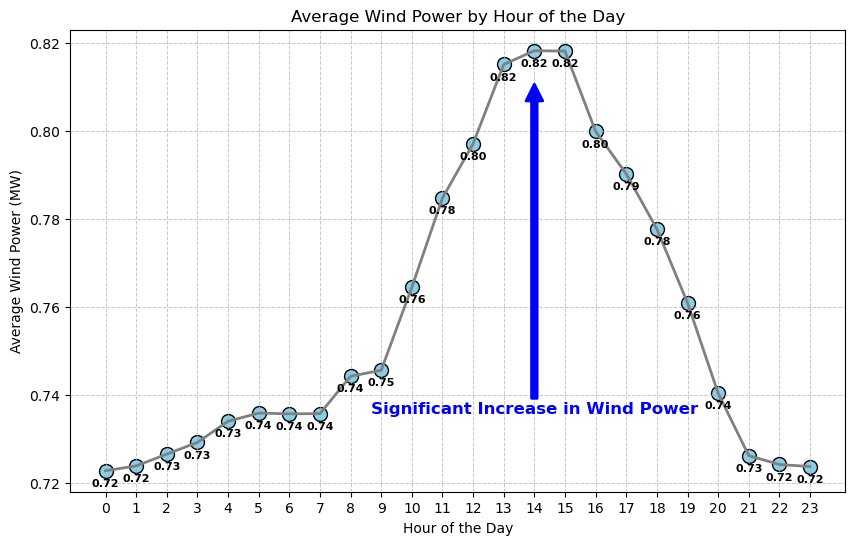

In [3853]:
# Extract hour from the 'date' column
df['hour'] = df['date'].dt.hour

# Calculate average wind power for each hour of the day
hourly_power = df.groupby('hour')['wdpr'].mean()

# Convert to MW for better readability
hourly_power_mw = hourly_power / 10**6

# Set up figsize
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(hourly_power_mw.index, hourly_power_mw.values, color='skyblue', edgecolor='black', s=100)

# Line plot connecting the points
plt.plot(hourly_power_mw.index, hourly_power_mw.values, color='gray', linewidth=2)

# Titles and labels
plt.title('Average Wind Power by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Wind Power (MW)')

# Add gridlines for better readability
plt.grid(which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=1)

# Set x-axis labels to be integers (hour)
plt.xticks(ticks=range(24), labels=[str(i) for i in range(24)], rotation=0)

# Add gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels to each point 
for i in range(len(hourly_power_mw)):
    plt.text(hourly_power_mw.index[i], hourly_power_mw.values[i]-0.004,  
             f'{hourly_power_mw.values[i]:.2f}', ha='center', va='bottom', 
             fontsize=8, fontweight='bold')  # Make the font bold
    
# Calculate a point in between the y-values of the 13th and 14th points
midpoint_y = (1/4) * hourly_power_mw[12] + (3/4) * hourly_power_mw[13]

# Annotate the 14th point with a perfectly vertical arrow
plt.annotate('Significant Increase in Wind Power', 
             xy=(14, midpoint_y),  # Point to annotate (14th hour)
             xytext=(14, hourly_power_mw[5]),  # Text placed vertically above/below the 14th point
             arrowprops=dict(color='blue', lw=2),  
             fontsize=12, color='blue', fontweight='bold', ha='center')  # Center-align the text

# Show the plot
plt.show()


Throughout the day, wind power starts off pretty steady at around 0.73 MW in the early morning (Hours 0-5) and gradually increases to 0.82 MW around 2-3 PM, which is about a 12-13% increase. This peak happens in the afternoon, and after that, the wind power starts to drop a bit, staying around 0.78 MW in the late afternoon (Hours 16-19). By the evening and night, it drops further to 0.72 MW by late night (Hours 22-23), which is also a 12-13% decrease from the afternoon peak. So, overall, we see the strongest winds in the afternoon and the weakest at night, with pretty steady wind in the early morning and evening.

#### Analysis of the wind power per month & season of the year

In this sub-section we examine the average wind power generated per month in Ireland. The `date` column is used to extract the month, which is then mapped to Irish calendar seasons (e.g., Spring, Summer) [[79]](79) [[80]](80) [[81]](81). The average wind power (`wdpr`) for each month is calculated and converted to megawatts (MW). A bar chart is created to visualize the monthly averages, with bars color-coded according to their corresponding season [[13]](13) [[75]](75). Data labels are added above each bar, and a legend is included to represent the seasons. The x-axis is labeled with month names for clarity, providing a clear depiction of seasonal wind power trends.

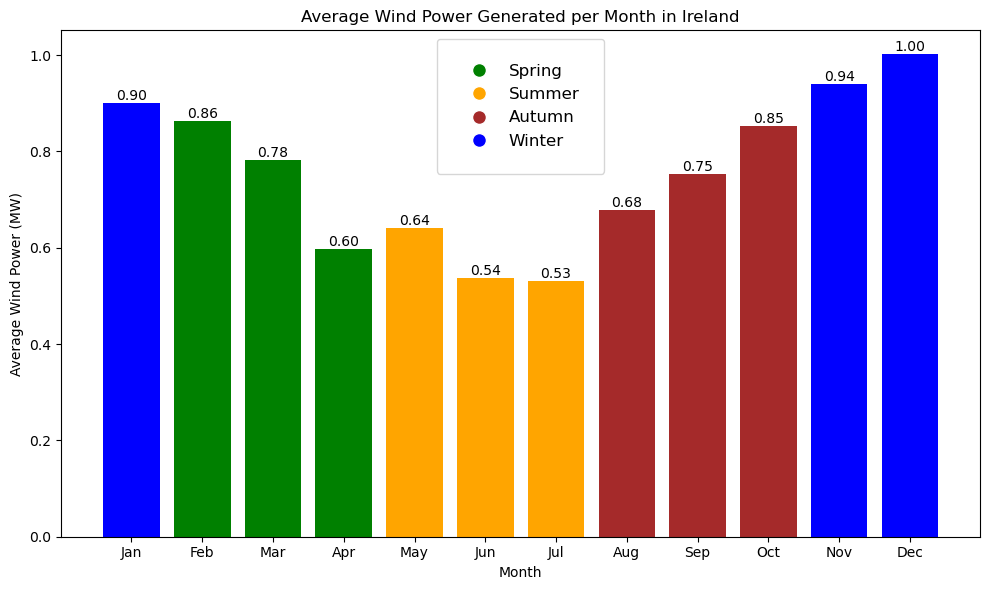

In [3854]:
# Extract month from the 'date' column
df['month'] = df['date'].dt.month

# Define Irish calendar seasons
irish_seasons = {
    2: 'Spring', 3: 'Spring', 4: 'Spring',
    5: 'Summer', 6: 'Summer', 7: 'Summer',
    8: 'Autumn', 9: 'Autumn', 10: 'Autumn',
    11: 'Winter', 12: 'Winter', 1: 'Winter'
}

# Map months to Irish seasons
df['season'] = df['month'].map(irish_seasons)

# Calculate average wind power for each month
monthly_power = df.groupby('month')['wdpr'].mean()

# Convert to MW
monthly_power_mw = monthly_power / 10**6

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each season
season_colors = {
    'Spring': 'green',
    'Summer': 'orange',
    'Autumn': 'brown',
    'Winter': 'blue'
}

# Plot each month with the corresponding season color
bars = []
for month, power in monthly_power_mw.items():
    season = df.loc[df['month'] == month, 'season'].iloc[0]  # Get season for the month
    bar = ax.bar(month, power, color=season_colors[season])
    bars.append(bar)

    # Add data label above each bar (using the individual bar rectangle)
    for b in bar:
        ax.text(b.get_x() + b.get_width() / 2, b.get_height(), 
                f'{b.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Set axis labels
ax.set_xlabel('Month')
ax.set_ylabel('Average Wind Power (MW)')
ax.set_title('Average Wind Power Generated per Month in Ireland')

# Define custom legend handles for each season
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
                  for color in season_colors.values()]
legend_labels = list(season_colors.keys())

# Create a legend at the top center, with items stacked vertically
ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1, 
          fontsize=12, frameon=True, borderpad=1.5, handlelength=2)

# Set x-axis to show month names
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Display the plot
plt.tight_layout()
plt.show()

When we analyse the mean wind power by month of the year it reveals that wind power is highest in December (1.00 MW) and November (0.96 MW), followed by January (0.91 MW), indicating stronger wind conditions during the winter months. Wind power tends to decrease in the spring and summer months, with the lowest averages recorded in June (0.52 MW) and July (0.53 MW). Spring months (March to May) show moderate wind power, ranging from 0.58 MW in April to 0.77 MW in March. Overall, the trend highlights the seasonal variation, with winter months exhibiting the highest wind power, and the summer months the lowest. 

## 5 -  Wind Speed Trend Over the Last Decades

To determine a trend of wind speed over the last few decades, let's plot the annual average wind speeds over time using linear regression to determine if there is a significant change.  
We start by extracting the year from the date column, and then the average wind speed (wdsp_ms) is calculated for each year [[82]](82). A linear regression is performed on the annual data to determine the trend, characterized by the slope and intercept of the best-fit line [[83]](83). The results are visualized with a scatter plot of annual average wind speeds and a trend line overlay [[78]](78). Key metrics from the regression analysis, including the slope, intercept, R-squared value, and p-value, are calculated and displayed to assess the significance and strength of the trend [[84]](84).

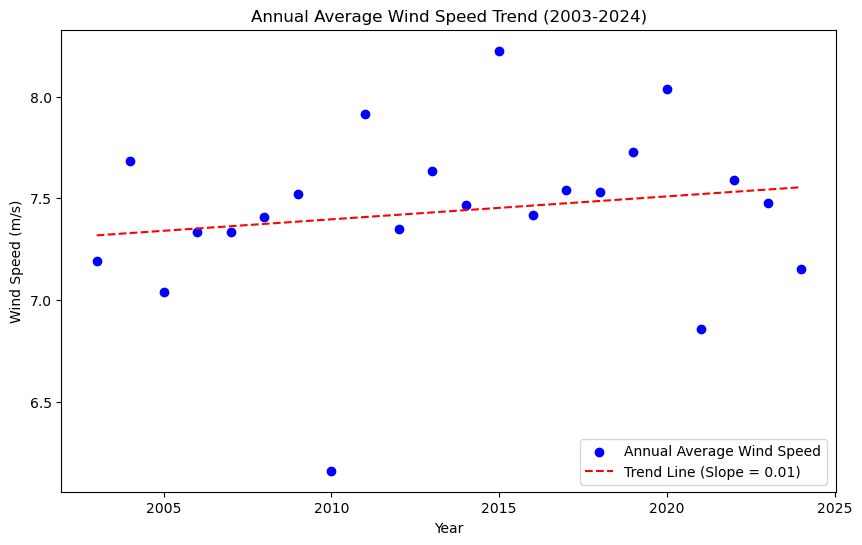

Linear Regression Results:
Slope: 0.01
Intercept: -15.23
R-squared: 0.03
P-value: 4.41e-01


In [3855]:
# Extract year from date column 
df['year'] = df['date'].dt.year

# Calculate annual average wind speeds 
annual_wind_speed = df.groupby('year')['wdsp_ms'].mean()

# Prepare data for linear regression: years (independent variable) and average wind speeds (dependent variable)
years = annual_wind_speed.index
wind_speeds = annual_wind_speed.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(years, wind_speeds)

# Plot the annual average wind speed data and the regression trend line
plt.figure(figsize=(10, 6))
plt.scatter(years, wind_speeds, label="Annual Average Wind Speed", color='blue')
plt.plot(years, intercept + slope * years, label=f"Trend Line (Slope = {slope:.2f})", color='red', linestyle='--')

# Add plot title, axis labels, and legend
plt.title('Annual Average Wind Speed Trend (2003-2024)')
plt.xlabel('Year')
plt.ylabel('Wind Speed (m/s)')
plt.legend(loc='lower left', bbox_to_anchor=(0.66, 0.00))

# Display the plot
plt.show()

# Print the results of the linear regression analysis
print(f"Linear Regression Results:")
print(f"Slope: {slope:.2f}")  # Indicates the rate of change in wind speed per year
print(f"Intercept: {intercept:.2f}")  # Y-intercept of the trend line
print(f"R-squared: {r_value**2:.2f}")  # Proportion of variance explained by the model
print(f"P-value: {p_value:.2e}")  # Statistical significance of the trend


The analysis shows that there isn’t a clear trend in wind speeds over the last few decades. While the slope of the trend line is small (0.01), suggesting a slight increase, the R-squared value is very low (0.03), indicating that the data does not fit the trend line well. Additionally, the p-value (4.46e-01) is higher than 0.05, meaning the trend is not statistically significant. Therefore, we cannot confidently assert that there is a real trend in wind speeds. It’s also important to note that the time period considered (2003-2024) spans only two decades, which might influence these results.

Based on this analysis, it’s likely that wind speeds will remain relatively stable over the next 10 years in Mace Head region. The lack of a clear trend in wind speeds makes it easier for wind farms to plan and operate, as they can expect consistent energy production. This stability allows investors to feel more confident and facilitates better design without concerns about significant long-term changes in wind patterns. However, wind farms should still account for short-term fluctuations and external factors. For instance, the lowest wind speed recorded in 2010 (6.16 m/s) was significantly lower than the highest wind speed recorded in 2015 (8.22 m/s), highlighting potential year-to-year variations.

## 6 -  Influence of the Temperature and Rain Precipitation to the Windspeed

In this section let's explore the impact of the temperature and rain to the windspeed. To do that, a 3D scatter plot and OLS regression analysis will also be conducted.

### 3D Plot

Here we visualize the relationship between rain, temperature, and wind speed using a 3D scatter plot [[85]](85). Rain and temperature are plotted as independent variables on the x- and y-axes, while wind speed is shown as the dependent variable on the z-axis. Each point represents a data observation, and the color of the points, determined by a colormap, indicates wind speed intensity [[86]](86). Labels, a color bar, and a title are added to enhance interpretability of the plot, providing insights into how these variables interact [[87]](87).

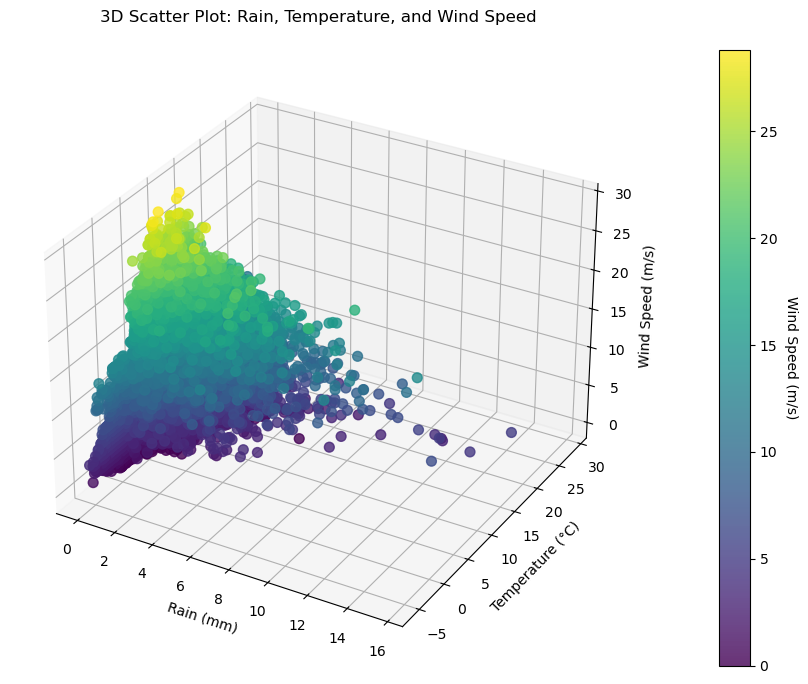

In [3856]:
# Extract variables
rain = df['rain']  # Rain (independent variable)
temperature = df['temp']  # Temperature (independent variable)
wind_speed = df['wdsp_ms']  # Wind Speed (dependent variable)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(rain, temperature, wind_speed, c=wind_speed, cmap='viridis', marker='o', s=50, alpha=0.8)

# Add color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Wind Speed (m/s)', rotation=270, labelpad=15)

# Set labels
ax.set_xlabel('Rain (mm)')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('Wind Speed (m/s)')

# Set title
ax.set_title('3D Scatter Plot: Rain, Temperature, and Wind Speed', pad=20)

# Show plot
plt.show()

The 3D scatter plot reveals the relationship between Rain (mm), Temperature (°C), and Wind Speed (m/s). The plot shows points with higher wind speeds (y-axis) tend to occur at higher rainfall levels (x-axis), suggesting a positive relationship between rain and wind speed. Temperature, however, does not exhibit a strong linear relationship with wind speed, with higher wind speeds appearing across a wide range of temperatures, primarily clustered in moderate ranges.

### OLS Regression Results

Then below we have a multiple linear regression analysis to investigate the relationship between wind speed (`wdsp_ms`) as the dependent variable and rain (`rain`) and temperature (`temp`) as independent variables. A constant term is added to account for the intercept in the model [[88]](88). The regression analysis is conducted using the Ordinary Least Squares (OLS) method, and the results, including coefficients, statistical significance, and goodness-of-fit measures, are summarized in a printed output [[89]](89) [[90]](90).

In [3857]:
# Define dependent and independent variables
X = df[['rain', 'temp']]  # Independent variables: Rain and Temperature
y = df['wdsp_ms']         # Dependent variable: Wind Speed

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Perform the regression analysis
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                wdsp_ms   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2259.
Date:                Sun, 12 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:47:13   Log-Likelihood:            -5.1257e+05
No. Observations:              185429   AIC:                         1.025e+06
Df Residuals:                  185426   BIC:                         1.025e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6900      0.027    288.556      0.0

The OLS regression results indicate that the model, which explores the relationship between wind speed (wdsp_ms), rain, and temperature, is statistically significant, but has a low R-squared value of 0.024. This suggests that the model explains only 2.4% of the variation in wind speed, meaning other factors likely play a larger role. The coefficients show that rain has a positive impact on wind speed, with each mm increase in rain precipitation leading to an increase of 1.2485 m/s in wind speed, while temperature negatively impacts wind speed, with each Celcius degree increase in temperature decreasing wind speed by 0.0366 m/s. Both variables are statistically significant, but the overall model fit is poor. The 3D Scatter Plot reinforces the regression findings that rain has a more noticeable influence on wind speed compared to temperature. Additionally, the plot highlights clustering of data where rain is low and temperature is moderate, which suggests that environmental factors like seasonality or location may need further exploration. Despite the weak relationships observed, additional statistical analysis is recommended to better understand these interactions.

## 7 - Forecast of Power Output for Next Week

In this section we preprocess wind power data for modeling, apply different forecasting methods (Linear Regression, ARIMA, and Prophet), and visualize the results. we also calculate the expected total power output for the next week, offering a comprehensive view of wind power predictions.

### Set Up and Data Preprocessing

We begin by preprocesses wind power data (wdpr) for analysis by resampling it to daily averages, ensuring consistent daily frequency, and applying smoothing with a 7-day rolling mean and standard deviation to observe weekly trends [[91]](91) [[92]](92) [[93]](93) [[94]](94). It also introduces temporal lag features, including a 1-day lag to capture short-term dependencies and a 1-year lag to account for annual seasonality [[95]](95). After handling missing values, the resulting dataset is prepared for further analysis, such as identifying patterns or building predictive models [[63]](63).

In [3858]:
# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Resample the data to daily averages
daily_data = df['wdpr'].resample('D').mean() 

# Ensure the index has daily frequency
daily_data = daily_data.asfreq('D')  

# Rolling window for smoothing (7 days for weekly data)
df['rolling_mean'] = df['wdpr'].rolling(window=7).mean()
df['rolling_std'] = df['wdpr'].rolling(window=7).std()

# Create a DataFrame
daily_data = daily_data.to_frame(name='wdpr')  

# Create both 1-week lag and 1-year lag features
daily_data['lag_1'] = daily_data['wdpr'].shift(1)       
daily_data['lag_1_year'] = daily_data['wdpr'].shift(52) 

# Drop NaN
daily_data.dropna(inplace=True)

### Modeling Wind Power Data Using Linear Regression with Temporal Features

This script below prepares a feature matrix comprising 1-day and 1-year lagged wind power data to predict the current wind power levels. It splits the data into training and testing sets without shuffling to preserve temporal order [[96]](96). A linear regression model is trained on the training set and then used to generate predictions on the test set, providing a forecast of wind power based on the temporal lag features [[97]](97) [[98]](98).

In [3859]:
# Define the feature matrix with lagged features (1-day and 1-year lags)
X = daily_data[['lag_1', 'lag_1_year']]  # Feature matrix for prediction
y = daily_data['wdpr']                  # Target variable: current wind power data

# Split the data into training and testing sets
# Note: shuffle=False is used to preserve temporal order, crucial for time series analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
forecast = model.predict(X_test)  # Predicted wind power levels for the test set

### Forecasting Wind Power with an ARIMA Model

In this next script we prepare the wind power data for ARIMA modeling by ensuring a daily time series frequency [[92]](92). Then an ARIMA model is fitted to the data, with configurable parameters (p, d, q) for autoregression, differencing, and moving average components [[99]](99). The model generates a 49-day forecast, including confidence intervals, and displays the results for the final 7 days, providing insight into future wind power trends [[100]](100) [[101]](101) [[102]](102).

In [3860]:
# Ensure the index has daily frequency for time series consistency
daily_data = daily_data.asfreq('D')

# Convert the wind power data from Watts to Megawatts (MW)
daily_data['wdpr'] = daily_data['wdpr'] / 1e6  # 1 MW = 10^6 W

# Fit an ARIMA model to the wind power data in MW
# 'order=(p, d, q)' specifies the ARIMA parameters: 
# p = number of lag observations, d = degree of differencing, q = size of moving average window
model_arima = sm.tsa.ARIMA(daily_data['wdpr'], order=(5, 1, 0))  # Adjust (p, d, q) as needed
model_fit = model_arima.fit()

# Generate a forecast for the next 49 days
# Use get_forecast to include confidence intervals
forecast_arima = model_fit.get_forecast(steps=49)
forecast_arima_df = forecast_arima.summary_frame()  # Create a DataFrame with forecast and confidence intervals

# Print the last 7 days of the forecast in MW for review
print(forecast_arima_df.tail(7))


wdpr            mean   mean_se  mean_ci_lower  mean_ci_upper
2025-01-13  1.092268  1.657577      -2.156524       4.341060
2025-01-14  1.092268  1.674848      -2.190374       4.374910
2025-01-15  1.092268  1.691942      -2.223878       4.408414
2025-01-16  1.092268  1.708866      -2.257047       4.441583
2025-01-17  1.092268  1.725623      -2.289891       4.474427
2025-01-18  1.092268  1.742219      -2.322419       4.506955
2025-01-19  1.092268  1.758659      -2.354640       4.539176


The output shows a 7-day forecast of wind power (in MW), with the following key points:

- **`wdpr`**: Predicted wind power is **1.092 MW** for each day.
- **`mean_se`**: The standard error indicating forecast uncertainty (e.g., **1.657 MW** on January 13).
- **Confidence Intervals**: The forecast range for each day, with values ranging from negative to positive (e.g., **-2.156 MW to 4.341 MW** on January 13).

In short, the model predicts stable wind power at **1.092 MW**, but with considerable uncertainty, reflected in the wide confidence intervals.
We know that we won't have negative value for wind power generated. Let's improve this forecast with Prophet.

### Forecasting Wind Power with Prophet

The daily data will be reset and renamed for compatibility with Prophet’s required format (ds for date and y for wind power) [[103]](103). The model is then trained on the historical data, followed by the creation of a future dataframe to forecast the next 49 days. After generating predictions, the script extracts the predicted values (yhat), along with their confidence intervals (yhat_lower and yhat_upper), for the last 7 days of the forecast [[102]](102).

In [3861]:
# Prepare the data for Prophet: reset index and rename columns
df_prophet = daily_data.reset_index()[['date', 'wdpr']]
df_prophet.columns = ['ds', 'y']  # 'ds' for date and 'y' for wind power

# Initialize and fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Create a future dataframe for the next 49 days (daily frequency)
future_daily = model_prophet.make_future_dataframe(periods=49, freq='D')

# Generate predictions for the future period
daily_predictions = model_prophet.predict(future_daily)

# Extract the forecast for the last 7 days (predicted wind power and confidence intervals)
forecast_next_week_daily = daily_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)


21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing


### Visualizing and Summarizing the Last 7 Days of Wind Power Forecast

This script visualizes the forecasted wind power output for the last 7 days and calculates the expected total power output for the same period. It plots the forecasted power (yhat) with uncertainty intervals (yhat_lower and yhat_upper) as a shaded region [[48]](48) [[104]](104). Data labels for forecasted power are added for clarity. The plot includes a title, axis labels, and a grid for better readability. After plotting, it calculates the total expected power for the next week from the ARIMA forecast, assuming a model of a Vestas V52 turbine, and prints the result in MW.

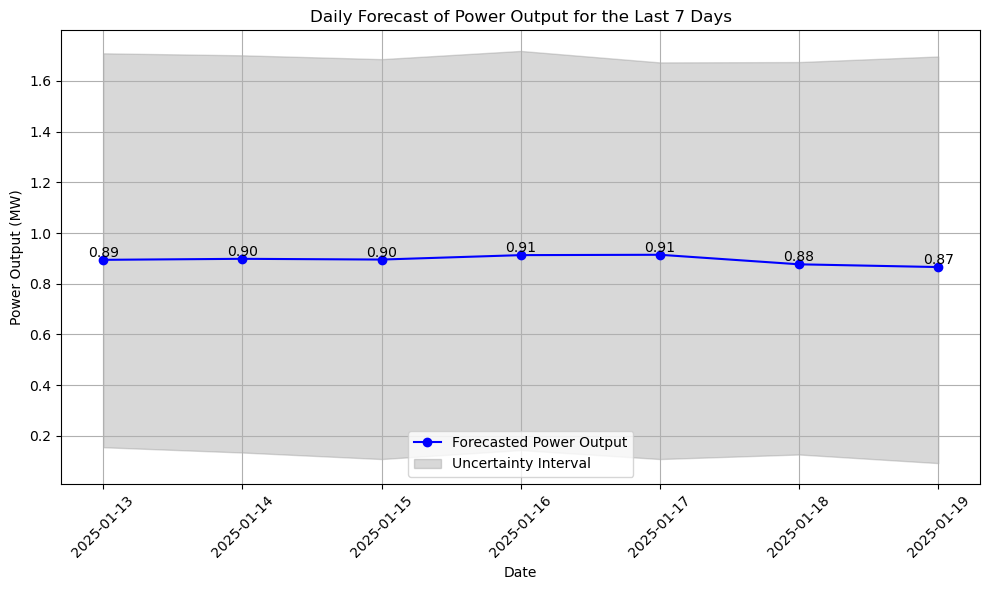


Mean Forecasted Power Output for the Last 7 Days: 0.89 MW

Expected Total Power for the Next Week for 1 turbine model Vestas V52: 7.65 MW


In [3862]:
# Get the last 7 rows of the forecasted data for visualization
forecast_last_7 = forecast_next_week_daily.tail(7)

# Plot the forecasted power output for the last 7 days
plt.figure(figsize=(10, 6))
plt.plot(forecast_last_7['ds'], forecast_last_7['yhat'], label='Forecasted Power Output', marker='o', linestyle='-', color='blue')

# Plot the uncertainty interval as a shaded area
plt.fill_between(
    forecast_last_7['ds'],
    forecast_last_7['yhat_lower'],
    forecast_last_7['yhat_upper'],
    color='gray',
    alpha=0.3,
    label='Uncertainty Interval'
)

# Add data labels for each forecasted power output value with vertical offset
for i, row in forecast_last_7.iterrows():
    plt.text(
        row['ds'], row['yhat'], 
        f"{row['yhat']:.2f}", 
        color='black', 
        ha='center', 
        va='bottom',  # Adjust vertical alignment to avoid overlap
        verticalalignment='center',  
        fontsize=10
    )

# Customize the plot with title, axis labels, and grid
plt.title('Daily Forecast of Power Output for the Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Power Output (MW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Calculate the mean of the forecasted power output for the last 7 days
mean_last_7 = forecast_last_7['yhat'].mean()

# Print the mean for the last 7 days
print(f"\nMean Forecasted Power Output for the Last 7 Days: {mean_last_7:.2f} MW")

# Calculate and print the total expected power output for the next week
total_power_next_week = forecast_arima_df['mean'].tail(7).sum()
print(f"\nExpected Total Power for the Next Week for 1 turbine model Vestas V52: {total_power_next_week:.2f} MW")


Here we analyzed the wind power forecasts for the next week using the Prophet model. The predictions show a stable power output of around 0.89 MW per day, with some uncertainty reflected in the confidence intervals. The total expected wind power for the next 7 days, based on the Prophet model, is 7.65 MW for a single Vestas V52 turbine. This result provides a reliable estimate of the expected power output while accounting for forecast uncertainties.

## Conclusion



***
# End